In [ ]:
!pip install rdkit
!pip install tokenizers
!pip install transformers


In [4]:
#=================== NLP aided prediction of Toxicity from SMILES ===================#

CUDA_LAUNCH_BLOCKING = "1"

import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from google.colab import drive
import math
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
import os
import seaborn as sb
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#drive.mount('/content/drive')

In [5]:
#path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
path = "DATA/fingerprint_df.csv"
df = pd.read_csv(path)

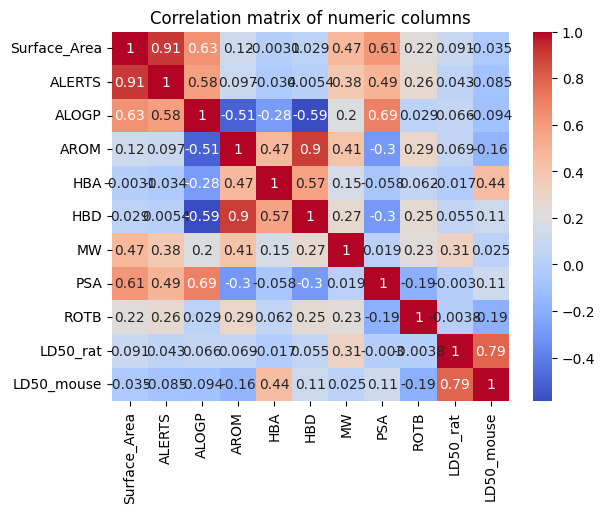

In [6]:
corr_mat = df.loc[:,["Surface_Area",'ALERTS','ALOGP','AROM','HBA','HBD','MW','PSA','ROTB','LD50_rat','LD50_mouse']].corr()

sb.heatmap(corr_mat, annot=True, cmap= "coolwarm")
plt.title("Correlation matrix of numeric columns")
plt.show()

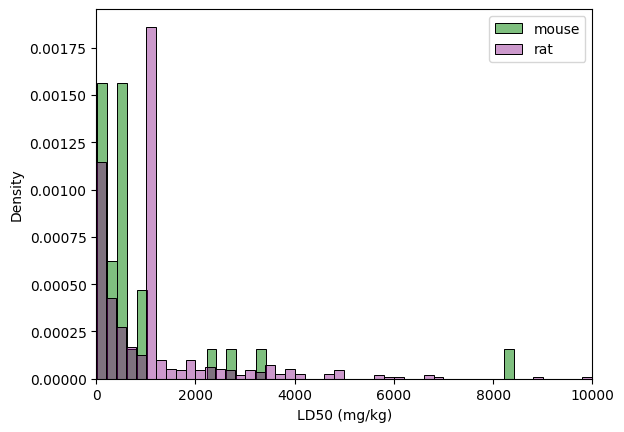

In [7]:
plt.figure()
plt.xlim(0,10000)
sb.histplot(df['LD50_mouse'],stat="density",alpha=0.5,binwidth=200,label="mouse",color="green")
sb.histplot(df['LD50_rat'],stat="density",alpha=0.4,binwidth=200,label="rat",color="purple")
plt.xlabel("LD50 (mg/kg)")
plt.legend()

In [8]:
print(len(df))
df = df.dropna(0,subset="LD50_rat")
print(len(df))

564
564


C:\Users\Pietro Willi\AppData\Local\Temp\ipykernel_40104\2448076796.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna(0,subset="LD50_rat")


In [9]:
binary_rat_ld50 = np.zeros(len(df))
binary_rat_ld50[np.argwhere(np.array(df["LD50_rat"])>df["LD50_rat"].median())] = 1

df["binary_rat_ld50"] = binary_rat_ld50

163.00000000000006
757.4000000000001
1010.0
1205.2000000000005


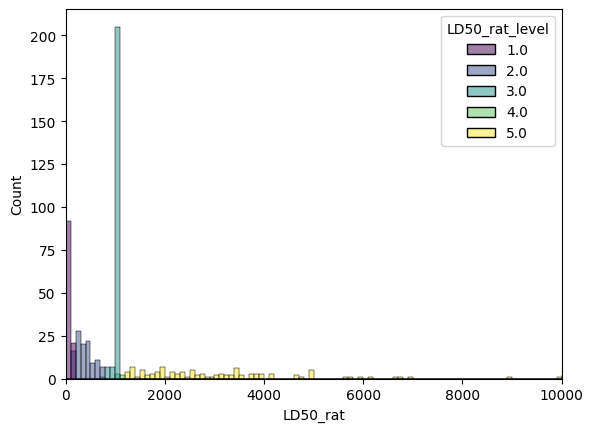

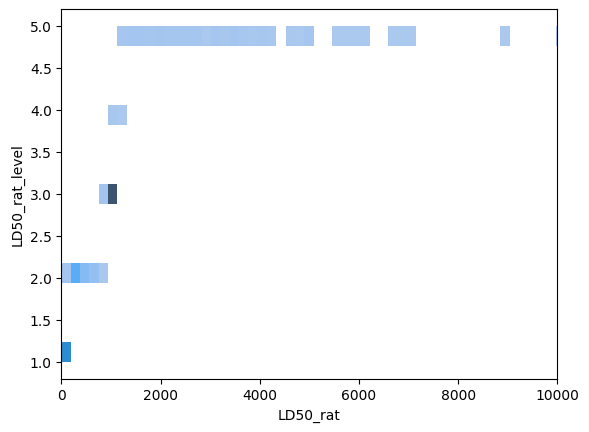

In [10]:
# creates a column called LD50_rat_level which is the categorization of the LD50 into 5 levels
def fivestar(df,col):
    df ["index"]=list(range(len(df)))
    df = df.set_index("index")
    first = df[col].quantile(0.2)
    onestar = df.query(f"{col}<={first}")
    df.loc[onestar.index, f"{col}_level"] = 1

    print(first)
    second = df[col].quantile(0.4)
    twostar = df.query(f"{col}<={second} and {col}>{first}")
    df.loc[twostar.index, f"{col}_level"] = 2
    print(second)
    third = df[col].quantile(0.6)
    threestar = df.query(f"{col}<={third} and {col}>{second}")
    df.loc[threestar.index, f"{col}_level"] = 3
    print(third)
    fourth = df[col].quantile(0.8)
    fourstar = df.query(f"{col}<={fourth} and {col}>{third}")
    df.loc[fourstar.index, f"{col}_level"] = 4
    print(fourth)
    fivestar = df.query(f"{col}>{fourth}")
    df.loc[fivestar.index, f"{col}_level"] = 5
    
    plt.figure()
    plt.xlim(0,10000)
    sb.histplot(data=df,x=col, hue=f"{col}_level",palette="viridis",binwidth=100)
    plt.savefig("data_level_distribution.pdf")
    plt.show()

    plt.figure()
    plt.xlim(0,10000)
    sb.histplot(data=df,y=f"{col}_level",x=col)
    plt.savefig("level_distribution.pdf")
    plt.show()
    
    return df

df = fivestar(df,"LD50_rat")

In [ ]:
#path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
#path = "DATA/fingerprint_df.csv"
#df.to_csv(path)

OSError: ignored

In [11]:

local = ["Surface_Area",'ALERTS','ALOGP','AROM','HBA','HBD','MW','PSA','ROTB',"moldb_smiles"]
for col in local:
    df[col] = df[col].astype(str)

df['text'] = df[local].agg(' '.join, axis=1)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

C:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pietro Willi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [13]:
pretrained = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english",num_labels=5,ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model = AutoModelForSequenceClassification.from_config(pretrained.config)

In [15]:
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, df, sequences: str, target: str, classification=True):
        super().__init__()
        self.df = df
        self.sequences = self.df[sequences].tolist()
        self.target = np.array(self.df[target]).astype(int)
        if classification:
            labels = len(np.unique(self.target))
            self.target = np.eye(labels)[self.target-1]

        self.inputs = tokenizer(self.sequences, padding=True, return_tensors="pt")
        self.inputs = self.inputs["input_ids"]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.inputs[idx], torch.tensor(self.target[idx])

In [16]:
random_seed = 1
df = df.sample(frac=1, random_state=random_seed)
train = df[:int(len(df)*0.7)]
test = df[int(len(df)*0.7):]
trainset = TokenDataset(train, "text", "LD50_rat_level")
testset = TokenDataset(test, "text", "LD50_rat_level")

batch_size=16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,drop_last=True)

In [17]:
device = torch.device("cuda")
model.to(device)
model.train()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 10
train_plot = []
best = 1
for epoch in tqdm(range(num_epochs)):
    J_train = J_val =  0 
    model.train()
    for batch in tqdm(trainloader):
        
        optimizer.zero_grad()
        inputs, targets = [item for item in batch]
        #targets = torch.argmax(batch['labels'], dim=-1)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs.squeeze())#, attention_mask=inputs['attention_mask'].squeeze()
        outputs = (torch.nn.functional.softmax(outputs[0])).float().to(device)
        J = loss(outputs, targets)
        train_plot.append(J.item())
        J_train += J
        J.backward()
        optimizer.step()
    model.eval()
    for batch in tqdm(testloader):
        with torch.no_grad():
            inputs, targets = [item for item in batch]
            inputs = inputs.to(device)
            targets = targets.to(device)
            data = model(inputs.squeeze())
            data = (torch.nn.functional.softmax(data[0])).float().to(device)
            J = loss(data, targets)
            J_val += J.item()
    if (J_val/len(testloader)) < best:
        best = (J_val/len(testloader))
        torch.save(model.state_dict(), f"Saved_models/huggingface_transformer_params.pth") ### saving the model with best validation loss is a bias!!!
    print(f"\rEpoch {epoch+1}; train loss: {J_train/len(trainloader):1.5f}\t val loss: {J_val/len(testloader):1.5f}")
    print(f"loss: {J_train/len(trainloader)}")
    

ma_train = np.convolve(train_plot, np.ones((len(trainloader)))/len(trainloader),mode="valid")
plt.plot(np.linspace(0,len(train_plot)-1,len(ma_train)),ma_train,c="tab:orange")

plt.plot(train_plot,c="tab:orange",alpha=0.3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.22 GiB already allocated; 0 bytes free; 3.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#========================== Evaluation ==========================#
model.eval()

evaluation = []
for batch in tqdm(testloader):
        with torch.no_grad():
            inputs, targets = [item for item in batch]
            inputs = inputs.to(device)
            targets = targets.to(device)
            data = model(inputs.squeeze())
            data = (torch.nn.functional.softmax(data[0])).float().to(device)
            
            J = loss(data, targets)
            J_val += J.item()

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-57-1842a4427ab4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = (torch.nn.functional.softmax(data[0])).float().to(device)


In [ ]:
targets

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [ ]:
data

tensor([[0.0060, 0.0072, 0.9588, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0268],
        [0.0060, 0.0072, 0.9588, 0.0011, 0.0269],
        [0.0060, 0.0072, 0.9587, 0.0011, 0.0269]], device='cuda:0')